### trying to impliment the espcn paper (paper number 3)

## Methodology:
1. convoloving the filter as usual on the images with relu activation. (test with tanh)
2. before passing it to ANNs we apply a sub-pixel layer 
3. pass the network in the training loop 

In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn.utils import clip_grad_norm_
import numpy as np
from dataloader_1 import *
from torch.utils.tensorboard import SummaryWriter

In [4]:
#laoding the data.
test_loader=CustomDataset.load_dataloader(r'C:\Users\Ankit\Documents\Vedanshi\ML-hands-on\my implimentations\data_test.pth',64)
train_loader=CustomDataset.load_dataloader(r'C:\Users\Ankit\Documents\Vedanshi\ML-hands-on\my implimentations\data_train.pth',64,False)	

In [5]:
class Net(nn.Module):
    def __init__(self, upscale_factor):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 3 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = F.tanh(self.conv1(x))
        x = F.tanh(self.conv2(x))
        x = F.sigmoid(self.pixel_shuffle(self.conv3(x)))
        return x

In [9]:
batch_size = 64
learning_rate = 0.001
num_epochs = 100
upscale_factor = 4

In [18]:
def calculate_psnr(img1, img2):
    mse = nn.MSELoss()(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def show_images(inputs, outputs, labels):
    fig, axs = plt.subplots(4, 3, figsize=(15, 15))
    for i in range(4):
        input_img = inputs[i].numpy().transpose((1, 2, 0))
        output_img = outputs[i].detach().numpy().squeeze()
        label_img = labels[i].numpy().squeeze()
       
        axs[i, 0].imshow(input_img)
        axs[i, 0].set_title("Low-Res Input")
        axs[i, 0].axis('off')
        axs[i, 1].imshow(output_img, cmap='gray')
        axs[i, 1].set_title("Model Output")
        axs[i, 1].axis('off')
        axs[i, 2].imshow(label_img, cmap='gray')
        axs[i, 2].set_title("Ground Truth")
        axs[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

Epoch [1/100], Step [0/137], Loss: 3239.1843, PSNR: -35.10
Epoch [1/100], Step [10/137], Loss: 1118.1344, PSNR: -30.48
Epoch [1/100], Step [20/137], Loss: 1518.8385, PSNR: -31.82
Epoch [1/100], Step [30/137], Loss: 3233.4290, PSNR: -35.10
Epoch [1/100], Step [40/137], Loss: 3179.9128, PSNR: -35.02
Epoch [1/100], Step [50/137], Loss: 1865.1293, PSNR: -32.71
Epoch [1/100], Step [60/137], Loss: 1950.9517, PSNR: -32.90
Epoch [1/100], Step [70/137], Loss: 2772.0181, PSNR: -34.43
Epoch [1/100], Step [80/137], Loss: 4543.4619, PSNR: -36.57
Epoch [1/100], Step [90/137], Loss: 2681.8286, PSNR: -34.28
Epoch [1/100], Step [100/137], Loss: 1488.4753, PSNR: -31.73
Epoch [1/100], Step [110/137], Loss: 3236.3428, PSNR: -35.10
Epoch [1/100], Step [120/137], Loss: 2979.0151, PSNR: -34.74
Epoch [1/100], Step [130/137], Loss: 2339.8032, PSNR: -33.69
Epoch [1/100], Average Loss: 2327.3248, Average PSNR: -33.17
Epoch [2/100], Step [0/137], Loss: 3204.2993, PSNR: -35.06
Epoch [2/100], Step [10/137], Loss: 1

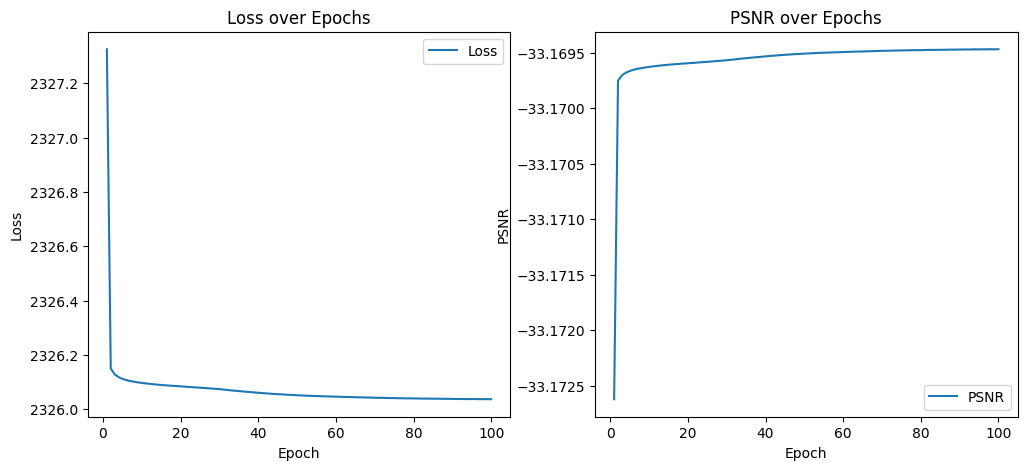

In [11]:
model = Net(upscale_factor=upscale_factor)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Store loss and PSNR values
loss_values = []
psnr_values = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_psnr = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Ensure target is upscaled to match the output dimensions
        target_upscaled = F.interpolate(target, size=(data.size(2) * upscale_factor, data.size(3) * upscale_factor), mode='bicubic', align_corners=False)

        output = model(data)
        loss = criterion(output, target_upscaled)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_psnr += calculate_psnr(output, target_upscaled).item()

        if batch_idx % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}, PSNR: {calculate_psnr(output, target_upscaled).item():.2f}')

    # Average loss and PSNR for the epoch
    avg_loss = epoch_loss / len(train_loader)
    avg_psnr = epoch_psnr / len(train_loader)
    loss_values.append(avg_loss)
    psnr_values.append(avg_psnr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Average PSNR: {avg_psnr:.2f}')

# Plot loss and PSNR values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), psnr_values, label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR over Epochs')
plt.legend()

plt.show()

In [ ]:
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, (low_res, high_res) in enumerate(test_loader):
        # Move inputs and labels to the same device as the model
        low_res = low_res.to(device)
        high_res = high_res.to(device)
        
        # Forward pass
        outputs = cnn_91(low_res)
        

## WITH RELU ACTIVATION AND NORMALIZED DATA and WEIGHT INITIALIZATION

In [12]:
import torch.nn.init as init

class Net_relu(nn.Module):
    def __init__(self, upscale_factor):
        super(Net_relu, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(32, 3 * (upscale_factor ** 2), (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.sigmoid(self.pixel_shuffle(self.conv3(x)))
        return x


In [13]:
norm_train=CustomDataset.load_dataloader(r'C:\Users\Ankit\Documents\Vedanshi\ML-hands-on\my implimentations\normalized_data_train.pth',64,True)
norm_test=CustomDataset.load_dataloader(r'C:\Users\Ankit\Documents\Vedanshi\ML-hands-on\my implimentations\data_train.pth',64,False)	

Epoch [1/100], Step [0/137], Loss: 3204.1882, PSNR: -35.06
Epoch [1/100], Step [10/137], Loss: 1115.0787, PSNR: -30.47
Epoch [1/100], Step [20/137], Loss: 1517.9413, PSNR: -31.81
Epoch [1/100], Step [30/137], Loss: 3232.9026, PSNR: -35.10
Epoch [1/100], Step [40/137], Loss: 3179.5205, PSNR: -35.02
Epoch [1/100], Step [50/137], Loss: 1864.8090, PSNR: -32.71
Epoch [1/100], Step [60/137], Loss: 1950.6873, PSNR: -32.90
Epoch [1/100], Step [70/137], Loss: 2771.8074, PSNR: -34.43
Epoch [1/100], Step [80/137], Loss: 4543.2930, PSNR: -36.57
Epoch [1/100], Step [90/137], Loss: 2681.6643, PSNR: -34.28
Epoch [1/100], Step [100/137], Loss: 1488.3208, PSNR: -31.73
Epoch [1/100], Step [110/137], Loss: 3236.1921, PSNR: -35.10
Epoch [1/100], Step [120/137], Loss: 2978.8923, PSNR: -34.74
Epoch [1/100], Step [130/137], Loss: 2339.6750, PSNR: -33.69
Epoch [1/100], Average Loss: 2326.0374, Average PSNR: -33.17
Epoch [2/100], Step [0/137], Loss: 3204.1826, PSNR: -35.06
Epoch [2/100], Step [10/137], Loss: 1

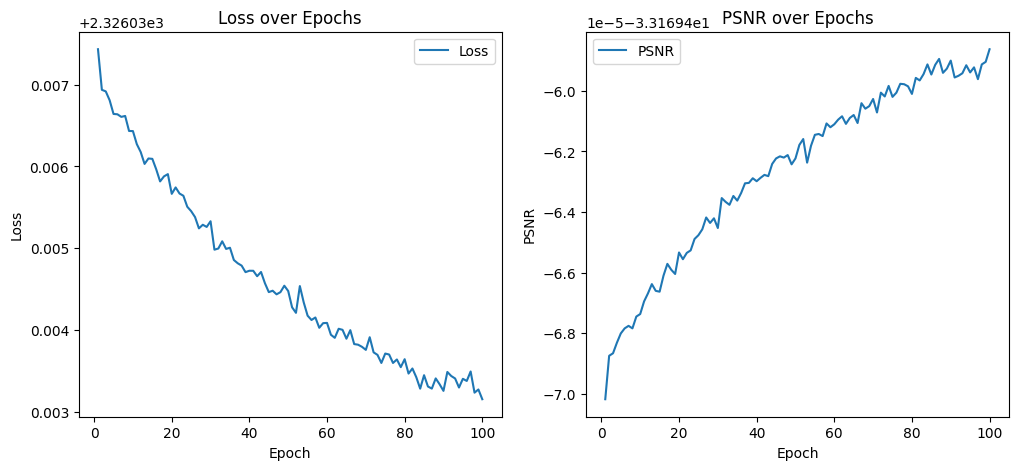

In [17]:
model_relu = Net_relu(upscale_factor=upscale_factor)
criterion = nn.MSELoss()
#for tensorboard, which is not working.
writer = SummaryWriter(log_dir='logs')

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_values = []
psnr_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_psnr = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()

        # Ensure target is upscaled to match the output dimensions
        target_upscaled = F.interpolate(target, size=(data.size(2) * upscale_factor, data.size(3) * upscale_factor), mode='bicubic', align_corners=False)

        output = model(data)
        loss = criterion(output, target_upscaled)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_psnr += calculate_psnr(output, target_upscaled).item()

        if batch_idx % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}, PSNR: {calculate_psnr(output, target_upscaled).item():.2f}')
            writer.add_scalar('training_loss', loss.item(), epoch * len(train_loader) + batch_idx)
            writer.add_scalar('training_psnr', calculate_psnr(output, target_upscaled).item(), epoch * len(train_loader) + batch_idx)

    # Average loss and PSNR for the epoch
    avg_loss = epoch_loss / len(train_loader)
    avg_psnr = epoch_psnr / len(train_loader)
    loss_values.append(avg_loss)
    psnr_values.append(avg_psnr)
    writer.add_scalar('epoch_training_loss', epoch_loss / len(train_loader), epoch)
    writer.add_scalar('epoch_training_psnr', epoch_psnr / len(train_loader), epoch)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Average PSNR: {avg_psnr:.2f}')

# Plot loss and PSNR values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), psnr_values, label='PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR over Epochs')
plt.legend()

plt.show()